Reference - https://www.aclweb.org/anthology/P19-1477.pdf


In [114]:
from transformers import BertTokenizer, BertModel, BertConfig, XLNetTokenizer, XLNetModel, XLNetConfig, BertForMaskedLM, RobertaConfig, RobertaTokenizer, RobertaModel, GPT2Config, GPT2Model, GPT2Tokenizer
import torch
import numpy as np
import matplotlib.pyplot as plt

In [38]:
def plot_attentions(attentions,tokens, layer_num, attention_head_num):
    
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(attentions)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(tokens)))
    ax.set_yticks(np.arange(len(tokens)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(tokens)
    ax.set_yticklabels(tokens)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    #for i in range(len(tokens)):
    #    for j in range(len(tokens)):
    #        text = ax.text(j, i, "{0:.1f}".format(float(attentions[i, j])),
    #                       ha="center", va="center", color="w")
    
    ax.set_title("Attention at layer {} attention head {}".format(layer_num, attention_head_num))
    fig.tight_layout()
    plt.show()

In [40]:
text = '[CLS] life is defined more by its [MASK] than by its samenesses. [SEP] risks [SEP]'

In [46]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',add_special_tokens=False)
indices = torch.LongTensor(np.asarray(tokenizer.encode(text,add_special_tokens=False))[np.newaxis,:])
tokens = tokenizer.tokenize(text)
print (tokens)
config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True, output_attentions=True) #total 4 outputs

#out[0] is last_hidden_state (torch.FloatTensor of shape (batch_size, sequence_length, hidden_size))
#out[1] is pooler_output (torch.FloatTensor: of shape (batch_size, hidden_size). this is often not a good summary

# if output_hidden_states = True then 
#out[2] hidden_states (tuple(torch.FloatTensor), optional, returned when config.output_hidden_states=True). Length is 13 (12 layers + embedding)

# if output_attentions = True then
#out[3] attentions (tuple(torch.FloatTensor), optional, returned when config.output_attentions=True): Length is 12 (12 layers). Each layer has 12 attention heads. shape of each attention is [1,12,num_tokens,num_tokens]


bert = BertModel.from_pretrained('bert-base-uncased',config=config)
out = bert(indices)

['[CLS]', 'life', 'is', 'defined', 'more', 'by', 'its', '[MASK]', 'than', 'by', 'its', 'same', '##ness', '##es', '.', '[SEP]', 'risks', '[SEP]']


In [47]:
indices

tensor([[  101,  2166,  2003,  4225,  2062,  2011,  2049,   103,  2084,  2011,
          2049,  2168,  2791,  2229,  1012,   102, 10831,   102]])

In [52]:
mask_id = np.where(indices[0].numpy() == 103)[0][0]
mask_id

7

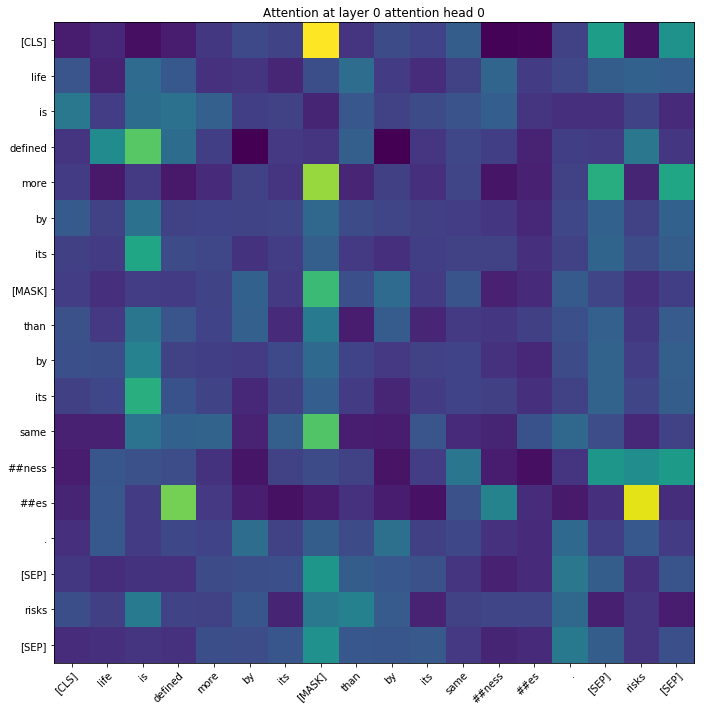

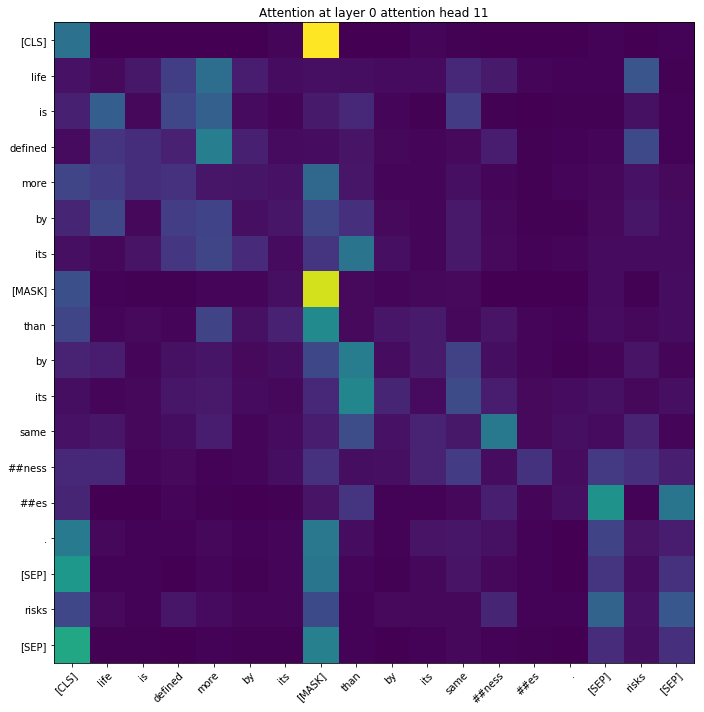

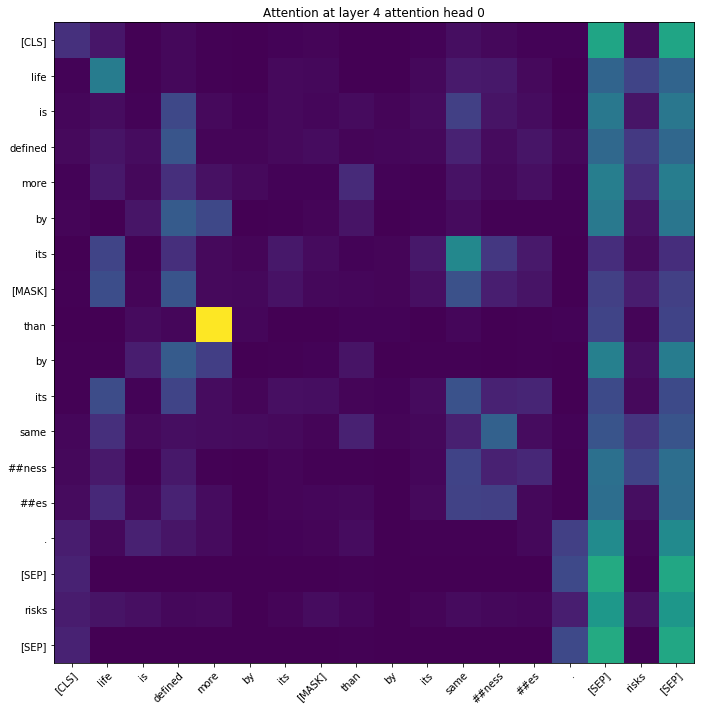

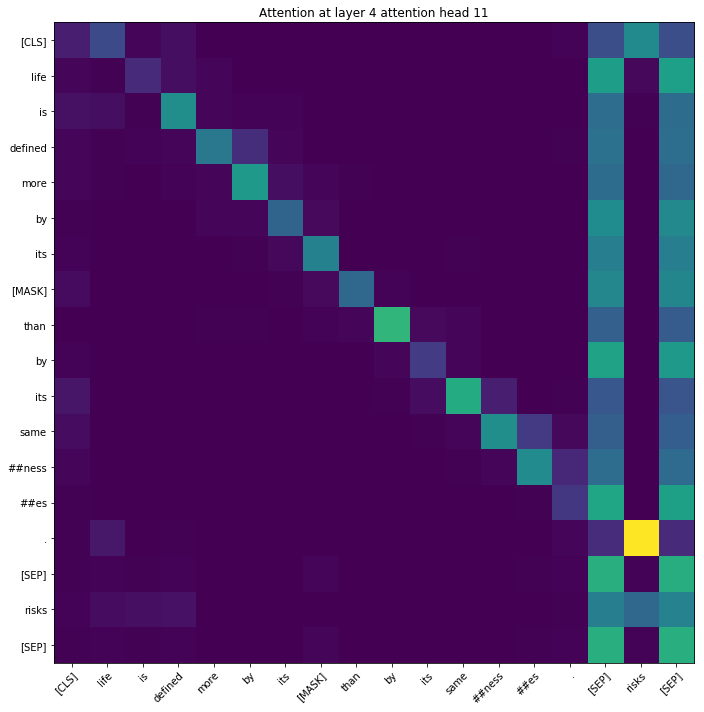

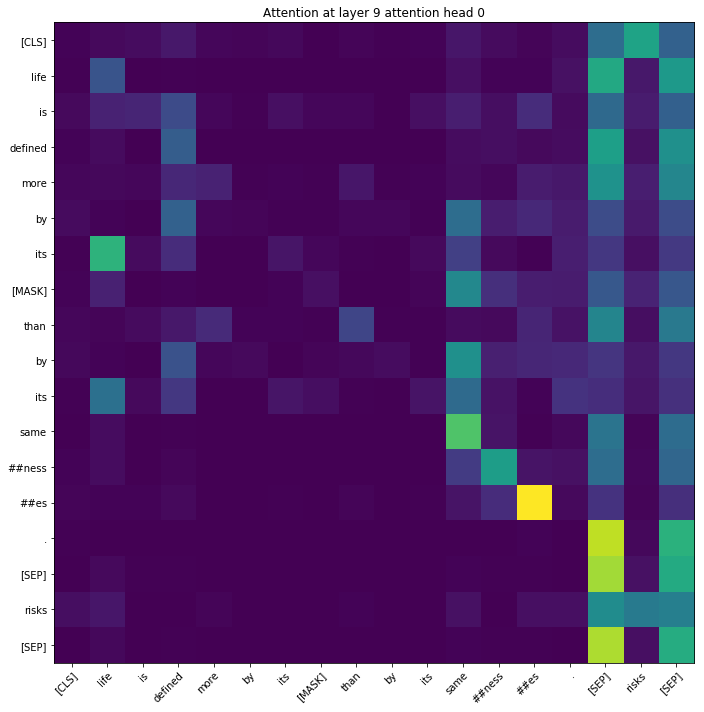

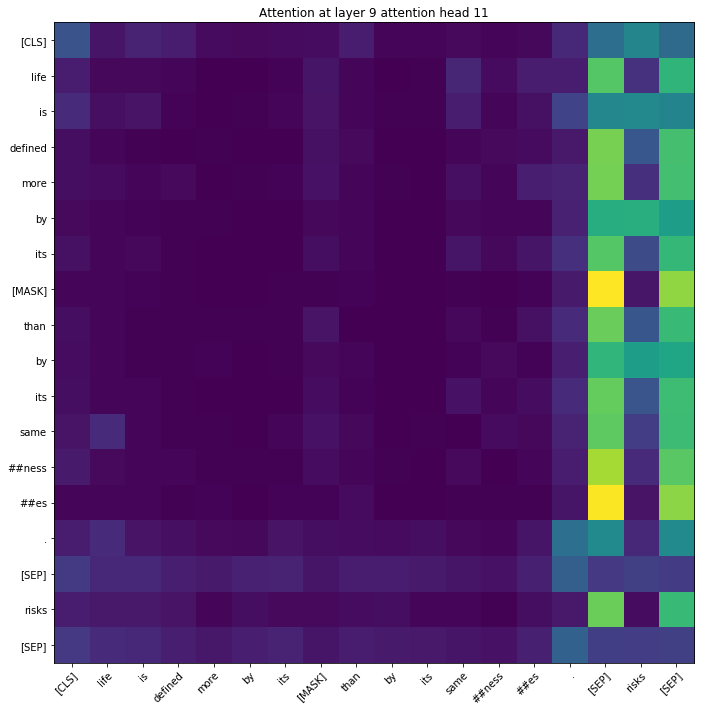

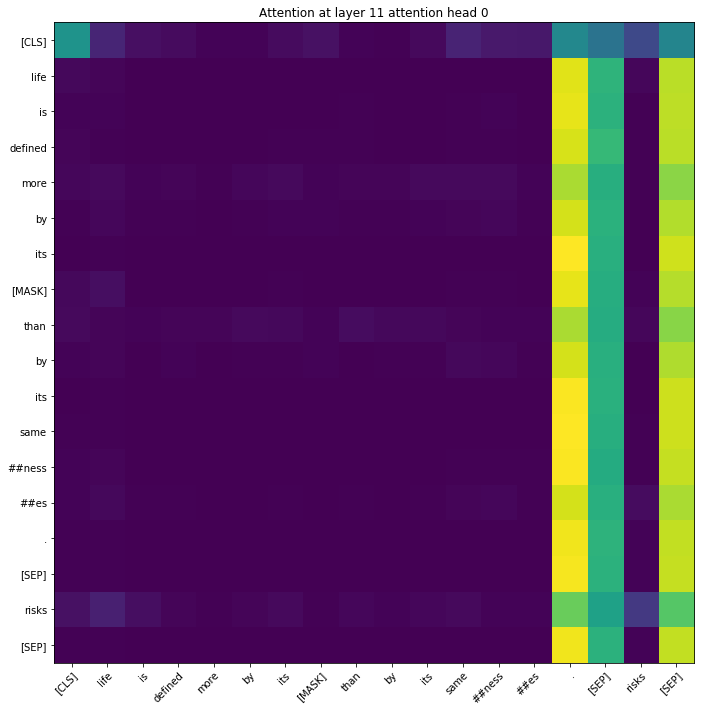

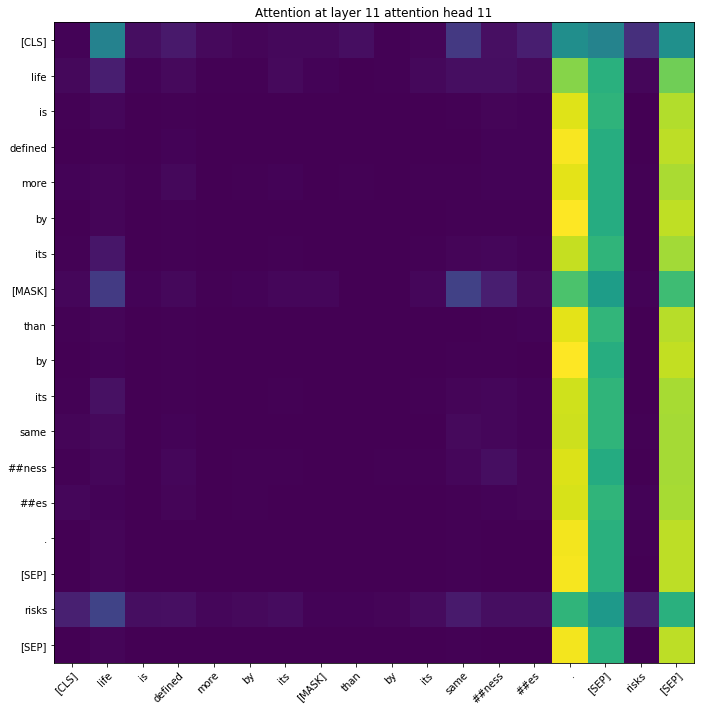

In [48]:
for i in [0,4,9,11]:
    for j in [0, 11]:
        plot_attentions(out[3][i][0,j,:,:].detach().numpy(),tokens,i,j)

In [53]:
# mode fusing

hidden_states = out[2]
hidden_layers = [-1,-3,-5,-7]
for i in range(len(hidden_layers)):
    if i == 0:
        hidden_layer = hidden_layers[i]
        hidden_state = hidden_states[hidden_layer].mean(dim=1) #average over all tokens
        #hidden_state = hidden_states[hidden_layer][:, 0] #take only the [CLS] token
        #hidden_state = hidden_states[hidden_layer][:, mask_id] #take only the [MASK] token
        #hidden_state = hidden_states[hidden_layer][:, -2] #take only the masked token
        fuse_hidden = torch.unsqueeze(hidden_state, dim=-1) # N * 768 * 1
    else:
        hidden_layer = hidden_layers[i]
        hidden_state = hidden_states[hidden_layer].mean(dim=1) #average over all tokens
        #hidden_state = hidden_states[hidden_layer][:, 0] #take only [CLS] token
        #hidden_state = hidden_states[hidden_layer][:, mask_id] #take only the [MASK] token
        #hidden_state = hidden_states[hidden_layer][:, -2] #take only the masked token
        h = torch.unsqueeze(hidden_state, dim=-1) # N * 768 * 1
        fuse_hidden = torch.cat([fuse_hidden, h], dim=-1)

print (fuse_hidden.shape)
fuse_hidden = fuse_hidden.reshape(fuse_hidden.shape[0], -1)
print (fuse_hidden.shape)

torch.Size([1, 768, 4])
torch.Size([1, 3072])


In [73]:
text = '[CLS] life is defined more by its [MASK] than by its samenesses. [SEP] risks [SEP]'

In [78]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased',add_special_tokens=False,mask_token='[MASK]',cls_token='[CLS]',sep_token='[SEP]')
indices = torch.LongTensor(np.asarray(tokenizer.encode(text,add_special_tokens=False))[np.newaxis,:])
tokens = tokenizer.tokenize(text)
print (tokens)
config = XLNetConfig.from_pretrained("xlnet-base-cased", output_hidden_states=True, output_attentions=True)
xlnet = XLNetModel.from_pretrained('xlnet-base-cased',config=config)

#out[0] is last_hidden_state (torch.FloatTensor of shape (batch_size, sequence_length, hidden_size))
#out[1] hidden_states (tuple(torch.FloatTensor), optional, returned when config.output_hidden_states=True). Length is 13 (12 layers + embedding)
#out[2] attentions (tuple(torch.FloatTensor), optional, returned when config.output_attentions=True): Length is 12 (12 layers). Each layer has 12 attention heads. shape of each attention is [1,12,num_tokens,num_tokens]


out = xlnet(indices)

['[CLS]', '▁life', '▁is', '▁defined', '▁more', '▁by', '▁its', '[MASK]', '▁than', '▁by', '▁its', '▁same', 'ness', 'es', '.', '[SEP]', '▁risks', '[SEP]']


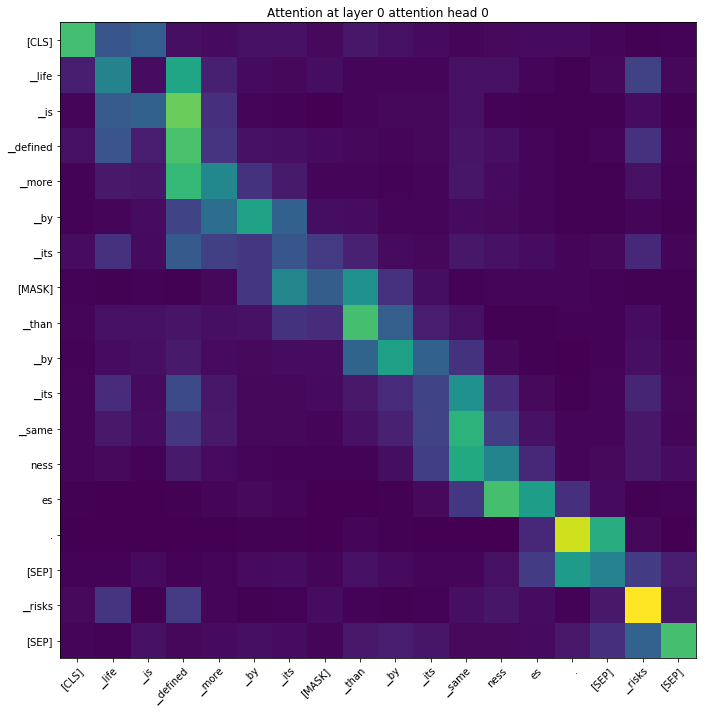

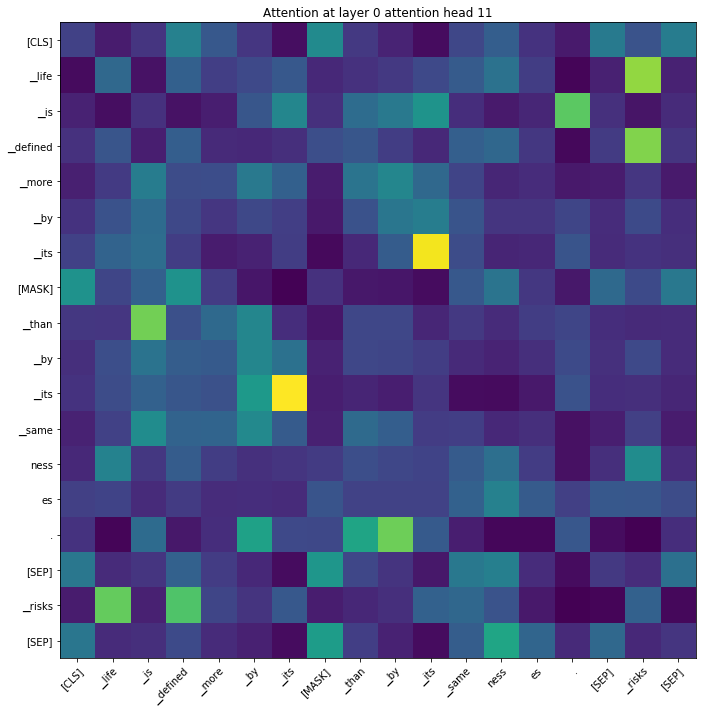

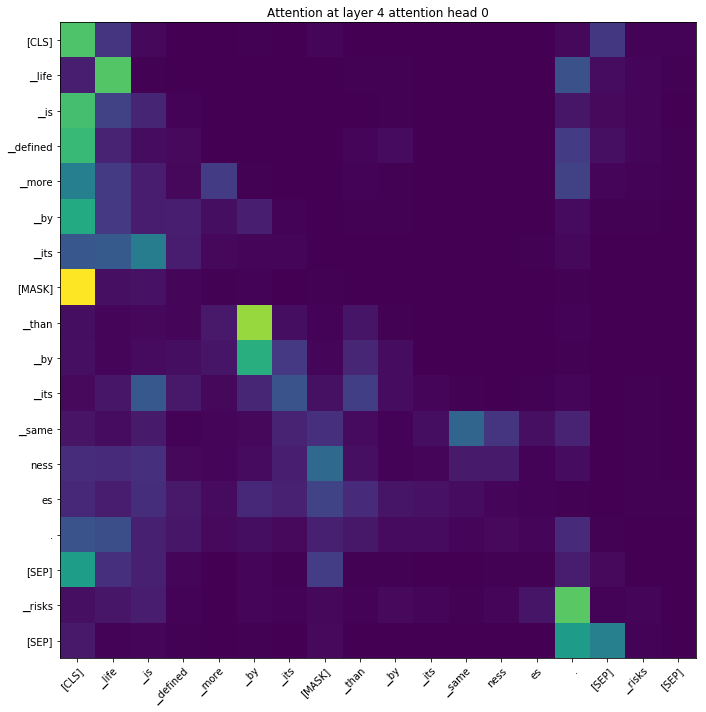

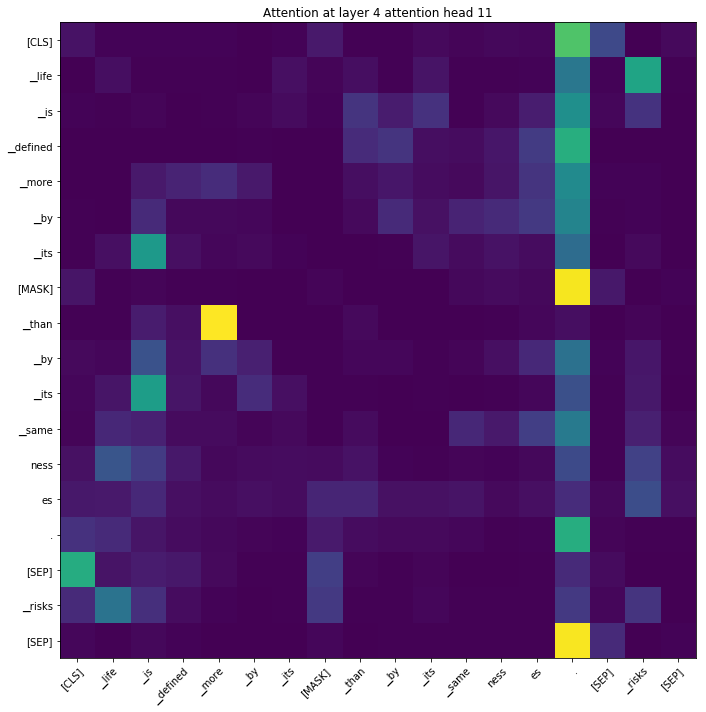

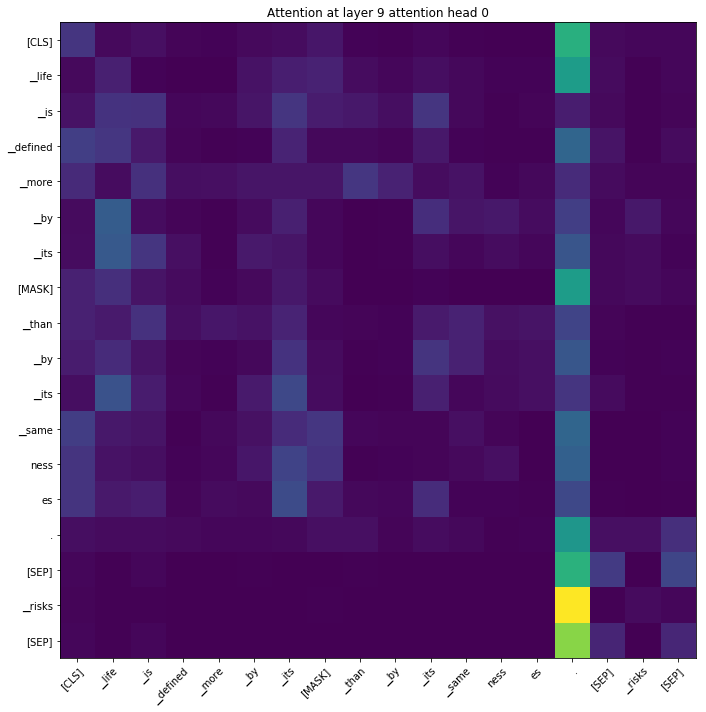

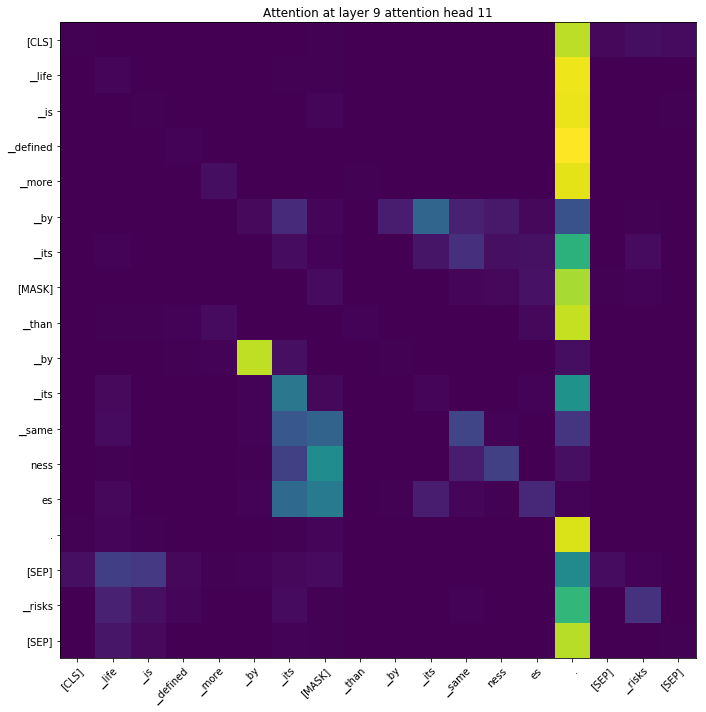

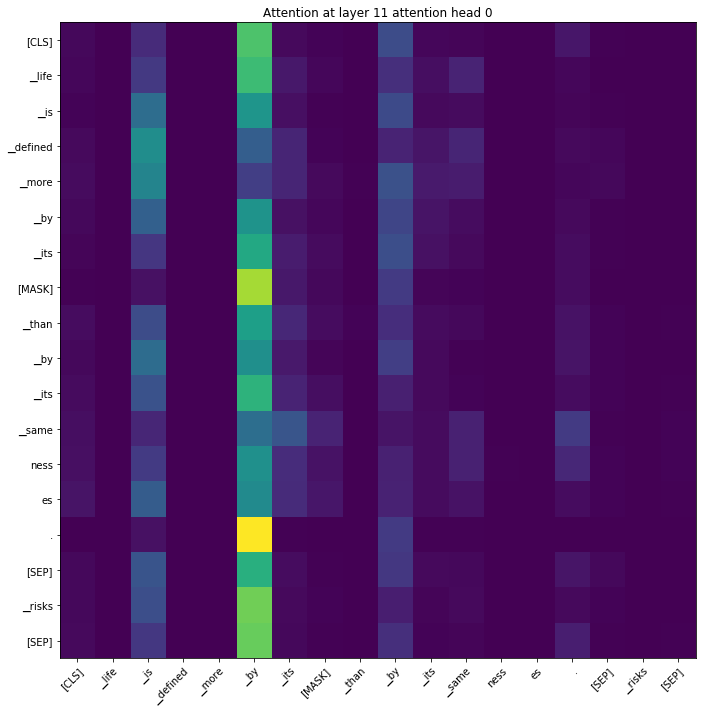

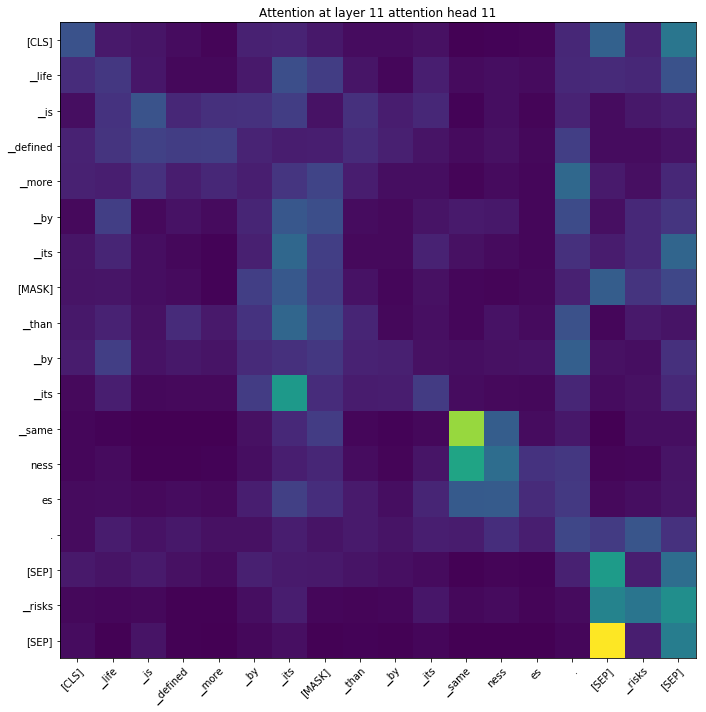

In [79]:
for i in [0,4,9,11]:
    for j in [0, 11]:
        plot_attentions(out[2][i][0,j,:,:].detach().numpy(),tokens,i,j)

In [112]:
text = '[CLS] life is defined more by its [MASK] than by its samenesses. [SEP]'

bert_model = BertForMaskedLM.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',add_special_tokens=False)
indices = torch.LongTensor(np.asarray(tokenizer.encode(text,add_special_tokens=False))[np.newaxis,:])
tokens = tokenizer.tokenize(text)
print (tokens)
print (indices)
mask_indices = np.where(indices[0].numpy() == 103)[0]
print (mask_indices)

pred = bert_model(indices)
predicted_indices = np.argmax( np.asarray(pred[0][0].detach().numpy())[mask_indices,:] ,axis=1)
predicted_words_decoded = tokenizer.decode(predicted_indices)

print ("Predicted sentence -")
print (text.replace("[CLS]","").replace("[SEP]","").replace("[MASK]",predicted_words_decoded).strip())

n_top=10
top_10_indices = np.argsort(np.asarray(pred[0][0].detach().numpy())[mask_indices,:], axis=1)[0,-n_top:]
top_10_words = tokenizer.decode(top_10_indices).split()
top_10_words.reverse()

print ("Top 10 predicted words")
print (top_10_words)

['[CLS]', 'life', 'is', 'defined', 'more', 'by', 'its', '[MASK]', 'than', 'by', 'its', 'same', '##ness', '##es', '.', '[SEP]']
tensor([[ 101, 2166, 2003, 4225, 2062, 2011, 2049,  103, 2084, 2011, 2049, 2168,
         2791, 2229, 1012,  102]])
[7]
Predicted sentence

life is defined more by its existence than by its samenesses.
Top 10 predicted words
['existence', 'nature', 'similarities', 'origin', 'actions', 'origins', 'causes', 'forms', 'experiences', 'history']


In [113]:
text = '[CLS] life is defined more by its risks than by its [MASK]. [SEP]'

bert_model = BertForMaskedLM.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',add_special_tokens=False)
indices = torch.LongTensor(np.asarray(tokenizer.encode(text,add_special_tokens=False))[np.newaxis,:])
tokens = tokenizer.tokenize(text)
print (tokens)
print (indices)
mask_indices = np.where(indices[0].numpy() == 103)[0]
print (mask_indices)

pred = bert_model(indices)
predicted_indices = np.argmax( np.asarray(pred[0][0].detach().numpy())[mask_indices,:] ,axis=1)
predicted_words_decoded = tokenizer.decode(predicted_indices)

print ("Predicted sentence -")
print (text.replace("[CLS]","").replace("[SEP]","").replace("[MASK]",predicted_words_decoded).strip())

n_top=10
top_10_indices = np.argsort(np.asarray(pred[0][0].detach().numpy())[mask_indices,:], axis=1)[0,-n_top:]
top_10_words = tokenizer.decode(top_10_indices).split()
top_10_words.reverse()

print ("Top 10 predicted words")
print (top_10_words)

['[CLS]', 'life', 'is', 'defined', 'more', 'by', 'its', 'risks', 'than', 'by', 'its', '[MASK]', '.', '[SEP]']
tensor([[  101,  2166,  2003,  4225,  2062,  2011,  2049, 10831,  2084,  2011,
          2049,   103,  1012,   102]])
[11]
Predicted sentence

life is defined more by its risks than by its benefits.
Top 10 predicted words
['benefits', 'rewards', 'risks', 'goals', 'costs', 'opportunities', 'cost', 'advantages', 'hazards', 'resources']


In [117]:
print ("Total number of parameters to learn {}".format(sum(p.numel() for p in bert.parameters() if p.requires_grad)))

Total number of parameters to learn 109482240


In [116]:
for name, param in bert.named_parameters():
    print (name, param.requires_grad) #make requires_grad=False in order to freeze any layer

embeddings.word_embeddings.weight True
embeddings.position_embeddings.weight True
embeddings.token_type_embeddings.weight True
embeddings.LayerNorm.weight True
embeddings.LayerNorm.bias True
encoder.layer.0.attention.self.query.weight True
encoder.layer.0.attention.self.query.bias True
encoder.layer.0.attention.self.key.weight True
encoder.layer.0.attention.self.key.bias True
encoder.layer.0.attention.self.value.weight True
encoder.layer.0.attention.self.value.bias True
encoder.layer.0.attention.output.dense.weight True
encoder.layer.0.attention.output.dense.bias True
encoder.layer.0.attention.output.LayerNorm.weight True
encoder.layer.0.attention.output.LayerNorm.bias True
encoder.layer.0.intermediate.dense.weight True
encoder.layer.0.intermediate.dense.bias True
encoder.layer.0.output.dense.weight True
encoder.layer.0.output.dense.bias True
encoder.layer.0.output.LayerNorm.weight True
encoder.layer.0.output.LayerNorm.bias True
encoder.layer.1.attention.self.query.weight True
encoder.

Different learning rate can be assigned like - 

    optim.SGD([
                {'params': model.base.parameters()},
                {'params': model.classifier.parameters(), 'lr': 1e-3}
            ], lr=1e-2, momentum=0.9)
            

Cosine Annealing Warm up

    >>> scheduler = CosineAnnealingWarmRestarts(optimizer, T_0, T_mult)
    >>> iters = len(dataloader)
    >>> for epoch in range(20):
    >>>     for i, sample in enumerate(dataloader):
    >>>         inputs, labels = sample['inputs'], sample['labels']
    >>>         scheduler.step(epoch + i / iters)
    >>>         optimizer.zero_grad()
    >>>         outputs = net(inputs)
    >>>         loss = criterion(outputs, labels)
    >>>         loss.backward()
    >>>         optimizer.step()

Exponential Moving Average of parameters - 
       
       class EMA(nn.Module):
           def __init__(self, mu):
               super(EMA, self).__init__()
               self.mu = mu
               self.shadow = {}

           def register(self, name, val):
               self.shadow[name] = val.clone()

           def forward(self, name, x):
               assert name in self.shadow
               new_average = self.mu * x + (1.0 - self.mu) * self.shadow[name]
               self.shadow[name] = new_average.clone()
               return new_average

       ema = EMA(0.999)
       for name, param in model.named_parameters():
           if param.requires_grad:
               ema.register(name, param.data)


In training loop

       optimizer.step()
       for name, param in model.named_parameters():
           if param.requires_grad:
                param.data = ema(name, param.data)